In [216]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from operator import itemgetter
import random
import igraph as ig
import teneto
from teneto import TemporalNetwork
import teneto.networkmeasures as tnet_m
from statsmodels.tsa.stattools import adfuller
import ruptures as rpt
from scipy import stats

### 1. Data preprocessing

In [217]:
Enron_events = pd.read_csv("Enron_events.txt", sep = "\t")
Enron_events["truetime"] = pd.to_datetime("2000-04-27 01:19:00") + pd.to_timedelta(Enron_events["time"], unit = "s") # to do daily aggregation
Enron_events

,time,exped,destin,truetime
0,1,52,119,2000-04-27 01:19:01
1,7741,119,99,2000-04-27 03:28:01
2,8701,119,5,2000-04-27 03:44:01
3,8701,119,52,2000-04-27 03:44:01
4,8701,119,109,2000-04-27 03:44:01
...,...,...,...,...
21262,63723194,83,37,2002-05-04 14:12:14
21263,63723235,37,83,2002-05-04 14:12:55
21264,66207973,37,136,2002-06-02 08:25:13
21265,66824454,37,23,2002-06-09 11:39:54


In [218]:
Enron_positions = pd.read_csv("Enron_positions.txt", sep = "\t", names = ["id", "person", "position"]) # because no header
Enron_positions["position"].fillna("unknown", inplace = True) # for better handling NA
Enron_positions

,id,person,position
0,1,allen-p,Manager
1,2,arnold-j,Manager
2,3,arora-h,Vice President
3,4,badeer-r,Director
4,5,bailey-s,unknown
...,...,...,...
142,143,zufferli-j,Vice President
143,144,guzman-m,Managing Director
144,145,hain-m,unknown
145,146,linder-e,Employee


In [219]:
nb_days = Enron_events["truetime"].dt.normalize().unique()
print("Number of days in data:", len(nb_days))
print("Number of persons in data:", len(Enron_positions))

Number of days in data: 633
Number of persons in data: 147


### 2. Time series for sent and received email 

In [220]:
# Make a profile per person: time serie of number of emails sent each month
Enron_count_sent_by_day = Enron_events.groupby([pd.Grouper(key = "truetime", freq = "1D"), "exped"]).agg(count_sent = ("exped", "count"))
Enron_count_sent_by_day.reset_index(inplace = True)
Enron_count_sent_by_day

,truetime,exped,count_sent
0,2000-04-27,6,2
1,2000-04-27,35,1
2,2000-04-27,42,1
3,2000-04-27,52,12
4,2000-04-27,97,2
...,...,...,...
7083,2002-05-04,37,2
7084,2002-05-04,83,1
7085,2002-06-02,37,1
7086,2002-06-09,37,1


In [221]:
Enron_count_received_by_day = Enron_events.groupby([pd.Grouper(key = "truetime", freq = "1D"), "destin"]).agg(count_received = ("destin", "count"))
Enron_count_received_by_day.reset_index(inplace = True)
Enron_count_received_by_day.head()

,truetime,destin,count_received
0,2000-04-27,5,7
1,2000-04-27,42,1
2,2000-04-27,44,1
3,2000-04-27,47,1
4,2000-04-27,52,5


In [222]:
# adding persons not presented in the count data (fill count data with 0)
missing_id_sent = Enron_positions.loc[~Enron_positions["id"].isin(Enron_count_sent_by_day["exped"]), "id"].values
for id in missing_id_sent:
    tmp = pd.DataFrame({"truetime": nb_days, "exped": id, "count_sent": 0})
    Enron_count_sent_by_day = Enron_count_sent_by_day.append(tmp, ignore_index = True)

missing_id_received = Enron_positions.loc[~Enron_positions["id"].isin(Enron_count_received_by_day["destin"]), "id"].values
for id in missing_id_received:
    tmp = pd.DataFrame({"truetime": nb_days, "destin": id, "count_received": 0})
    Enron_count_received_by_day = Enron_count_received_by_day.append(tmp, ignore_index = True)

#### 2.1. Visualizing time series for each group

The data tables created in this section are used only for visualization, not suited for k-means (for which we'll do properly in the next section)

In [223]:
Enron_count = pd.merge(
    Enron_count_sent_by_day, Enron_count_received_by_day,
    how = "outer",
    left_on = ["truetime", "exped"], right_on = ["truetime", "destin"]
)
Enron_count["id"] = Enron_count.apply(
    lambda row: row["exped"] if np.isnan(row["destin"]) else row["destin"],
    axis = 1
)
Enron_count.drop(["exped", "destin"], inplace = True, axis = 1)
Enron_count.fillna(0, inplace = True)
Enron_count = Enron_count.astype({"id": "int32", "count_sent": "int32", "count_received": "int32"})
Enron_count_with_title = pd.merge(Enron_count, Enron_positions)
Enron_count_with_title.head()


,truetime,count_sent,count_received,id,person,position
0,2000-04-27,2,0,6,bass-e,Trader
1,2000-04-29,1,0,6,bass-e,Trader
2,2000-05-02,3,0,6,bass-e,Trader
3,2000-05-09,2,0,6,bass-e,Trader
4,2000-05-16,2,0,6,bass-e,Trader


In [224]:
Enron_month = Enron_count_with_title.groupby([pd.Grouper(key = "truetime", freq = "M"), "position"]).sum()
Enron_month.drop(["id"], inplace = True, axis = 1)
Enron_month

count_sent  count_received
truetime   position                                     
2000-04-30 CEO                         1               0
           Director                    0               0
           Employee                   18              12
           Managing Director           2               6
           President                   0               2
...                                  ...             ...
2002-05-31 unknown                     1               2
2002-06-30 CEO                         0               1
           Director                    0               1
           Employee                    3               0
           unknown                     0               1

[243 rows x 2 columns]

<AxesSubplot:xlabel='truetime', ylabel='count_sent'>

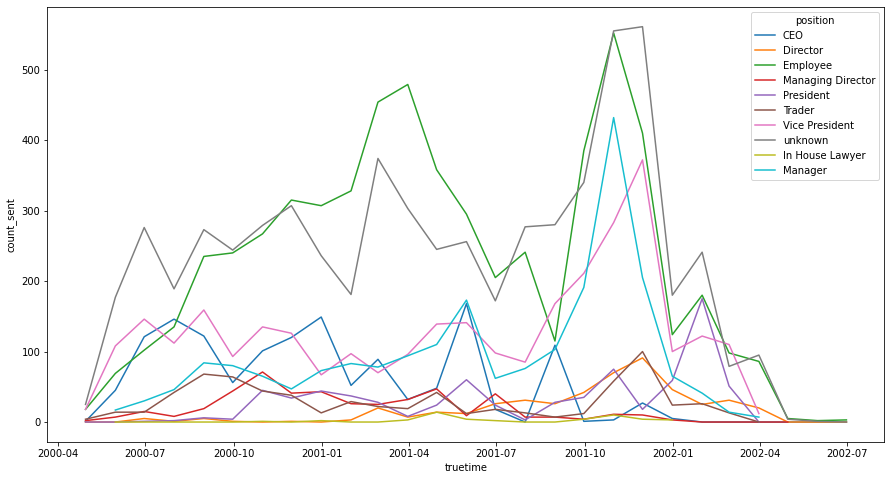

In [225]:
plt.figure(figsize=(15,8))
sns.lineplot(
    data = Enron_month, x = "truetime", y = "count_sent",
    hue = "position"
)

<AxesSubplot:xlabel='truetime', ylabel='count_received'>

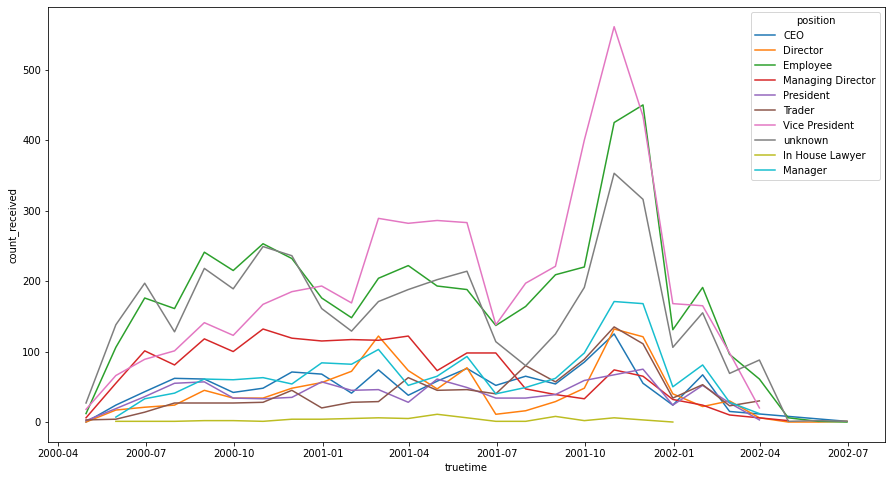

In [226]:
plt.figure(figsize=(15,8))
sns.lineplot(
    data = Enron_month, x = "truetime", y = "count_received",
    hue = "position"
)

In [227]:
sns.relplot(
    data = Enron_count_with_title, x = "truetime", y = "count_sent",
    hue = "position",
    col = "position", col_wrap = 3,
    kind = "line", legend = False, height = 7
)

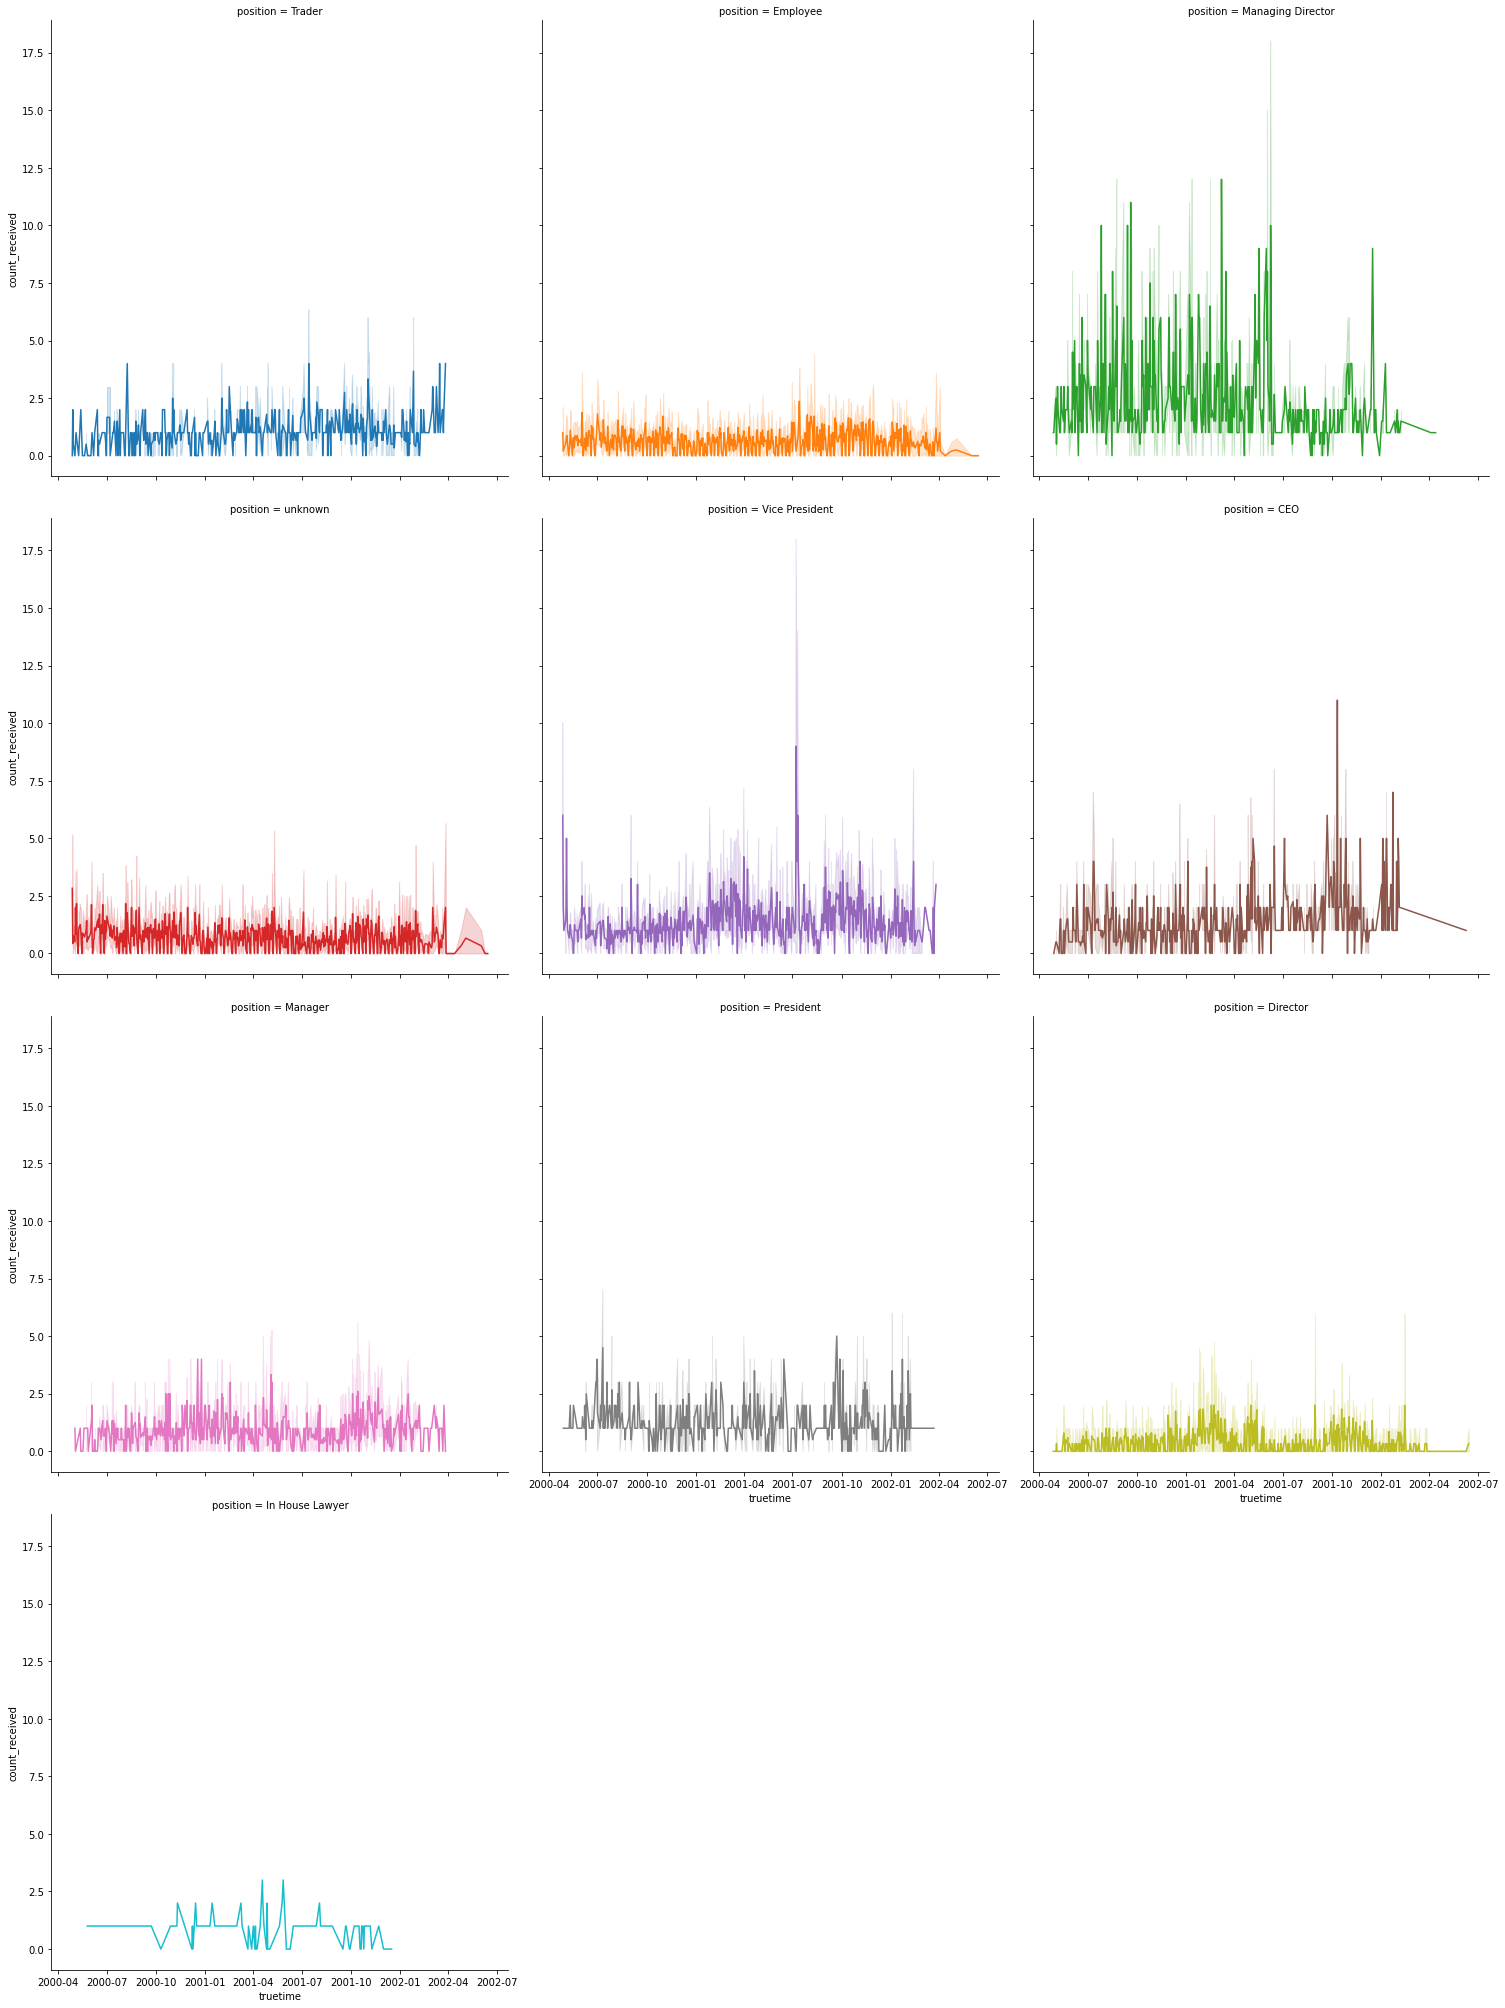

In [ ]:
sns.relplot(
    data = Enron_count_with_title, x = "truetime", y = "count_received",
    hue = "position",
    col = "position", col_wrap = 3,
    kind = "line", legend = False, height = 7
)

#### 2.2.Classify groups using the k-means method

We use k-means algorithm to find groups for each profile on data set, after that we can decise which positions in the company correspond to each group 
Because the package `tslearn` requires particular data format, we have to create the dataset properly

In [ ]:
# Pivot the table to have the matrix
Enron_sent_matrix = Enron_count_sent_by_day.pivot(index = "exped", columns = "truetime") # make the matrix
Enron_sent_matrix = Enron_sent_matrix.reindex(sorted(Enron_sent_matrix.columns), axis = 1) # make sure the daysid in chronological order, because the matrix will drop this info
Enron_sent_matrix = Enron_sent_matrix.sort_values(by = "exped") # make sure the ids in ascending order to match Enron_positions, because the matrix will drop this info
Enron_sent_matrix = Enron_sent_matrix.to_numpy(na_value = 0).astype("int32")[..., np.newaxis] # extra dim for tslearn package
print("Shape of the matrix of profile per peson of emails sent each day:", Enron_sent_matrix.shape, "(persons, days, extra dim for tslearn package)")

Shape of the matrix of profile per peson of emails sent each day: (147, 633, 1) (persons, days, extra dim for tslearn package)


In [ ]:
# Do the same for number of received emails
Enron_received_matrix = Enron_count_received_by_day.pivot(index = "destin", columns = "truetime")
Enron_received_matrix = Enron_received_matrix.reindex(sorted(Enron_received_matrix.columns), axis = 1)
Enron_received_matrix = Enron_received_matrix.sort_values(by = "destin")
Enron_received_matrix = Enron_received_matrix.to_numpy(na_value = 0).astype("int32")[..., np.newaxis]
print("Shape of the matrix of profile per peson of emails received each day:", Enron_sent_matrix.shape, "(persons, days, extra dim for tslearn package)")

Shape of the matrix of profile per peson of emails received each day: (147, 633, 1) (persons, days, extra dim for tslearn package)


In [ ]:
# k-means with DTW on emails-sent profiles
dtw_km_sent = dtw_km_received = TimeSeriesKMeans(n_clusters = 4, n_init = 3,  metric = "dtw", verbose = 1, n_jobs = 4)
cluster_sent = dtw_km_sent.fit_predict(Enron_sent_matrix)
cluster_received = dtw_km_received.fit_predict(Enron_received_matrix)

Init 1


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 |

375.782 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.2s finished


290.943 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


281.609 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


280.389 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.0s finished


280.291 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


280.007 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


279.968 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


279.968 --> 
Init 2


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 441 out of 441 |

442.190 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.7s finished


309.965 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


286.133 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


285.094 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


285.094 --> 
Init 3


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 441 out of 441 |

397.463 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.7s finished


307.545 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.2s finished


305.308 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


305.133 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


305.096 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


305.096 --> 


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Init 1


[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tas

107.959 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


82.653 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


82.228 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


82.228 --> 
Init 2


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 |

114.660 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


91.324 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


91.242 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.1s finished


91.242 --> 
Init 3


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 441 out of 441 |

124.510 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.0s finished


87.239 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.7s finished


83.862 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.7s finished


83.797 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.7s finished


83.308 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


83.070 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


83.056 --> 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.8s finished


83.056 --> 


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 588 out of 588 | elapsed:    1.7s finished


In [ ]:
cluster_sent

array([2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2, 1,
       0, 0, 0, 0, 0, 0, 2, 3, 0, 2, 0, 2, 0, 1, 0, 1, 1, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [ ]:
cluster_received

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 3, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1,
       3, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
Enron_positions_cluster = Enron_positions.copy()
Enron_positions_cluster["cluster_sent"] = cluster_sent
Enron_positions_cluster["cluster_received"] = cluster_received
Enron_positions_cluster.head()

,id,person,position,cluster_sent,cluster_received
0,1,allen-p,Manager,2,1
1,2,arnold-j,Manager,2,1
2,3,arora-h,Vice President,0,0
3,4,badeer-r,Director,0,0
4,5,bailey-s,unknown,0,1


In [ ]:
pd.crosstab(Enron_positions_cluster["cluster_sent"], Enron_positions_cluster["cluster_received"])

cluster_received,0,1,2,3
cluster_sent,,,,
0,86,10,0,2
1,5,5,1,0
2,14,19,3,0
3,0,2,0,0


In [ ]:
Enron_count_cluster = pd.merge(Enron_count, Enron_positions_cluster)
Enron_count_cluster.head()

,truetime,count_sent,count_received,id,person,position,cluster_sent,cluster_received
0,2000-04-27,2,0,6,bass-e,Trader,2,1
1,2000-04-29,1,0,6,bass-e,Trader,2,1
2,2000-05-02,3,0,6,bass-e,Trader,2,1
3,2000-05-09,2,0,6,bass-e,Trader,2,1
4,2000-05-16,2,0,6,bass-e,Trader,2,1


In [ ]:
# dtw_km_sent.cluster_centers_[0]

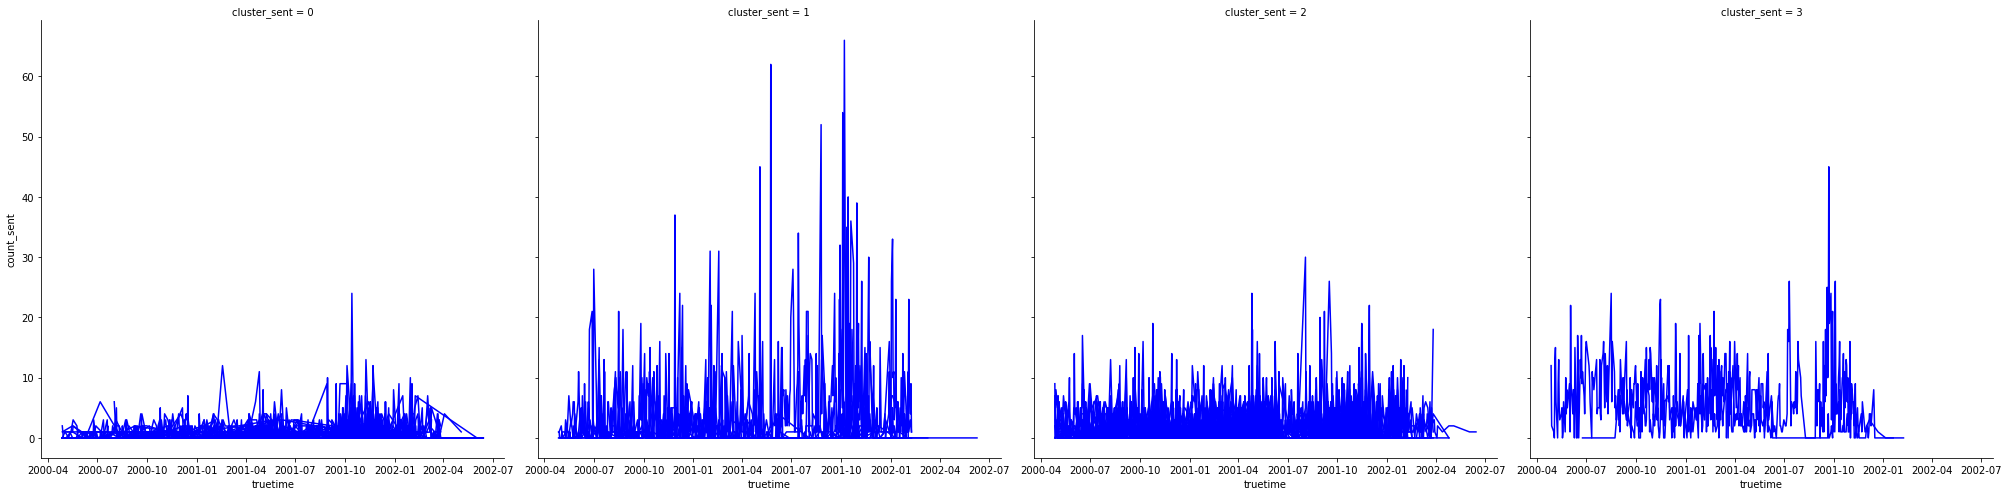

In [ ]:
sns.relplot(
    data = Enron_count_cluster, x = "truetime", y = "count_sent",
    hue = "id", palette = ["blue"] * Enron_count_with_title["id"].nunique(),
    col = "cluster_sent",
    kind = "line", legend = False, height = 7
)

#### Positions correspond to each group
We have 4 group of "sent email" and "received email"

In [ ]:
def to_df(cluster):
    group_dict=[]
    for i in range(0,4):
        group=dict(Enron_count_cluster.loc[Enron_count_cluster[cluster] == i, "position"].value_counts())
        group_dict.append(group)
    df=pd.DataFrame.from_records(group_dict).fillna(0)
    df.index=['group 0', 'group 1', 'group 2', 'group 3']
    df=df.astype(int).T
    return df


In [ ]:
# Number of people in each position for sent email
group_sent = to_df('cluster_sent')
group_sent

,group 0,group 1,group 2,group 3
Employee,3353,163,2234,323
unknown,2448,508,1477,332
Director,2083,0,101,0
Vice President,1390,171,1671,0
Trader,739,0,197,0
Manager,737,231,607,0
Managing Director,457,278,0,0
President,102,252,395,0
In House Lawyer,82,0,0,0
CEO,0,756,98,0


In [ ]:
# Number of people in each position for received email
group_received =to_df('cluster_received')
group_received

,group 0,group 1,group 2,group 3
Employee,4398,1675,0,0
unknown,2517,2248,0,0
Director,2074,110,0,0
Vice President,880,1477,535,340
Trader,739,197,0,0
Manager,737,838,0,0
CEO,207,249,398,0
President,102,647,0,0
Managing Director,94,278,0,363
In House Lawyer,82,0,0,0


### 3. Static network
Build a static network to summarize the interactions in the company. Some basic statistics indicate the characteristics of the network will be counted. They will help us examine the important vertices and specific group that this vertices share particular interactions.

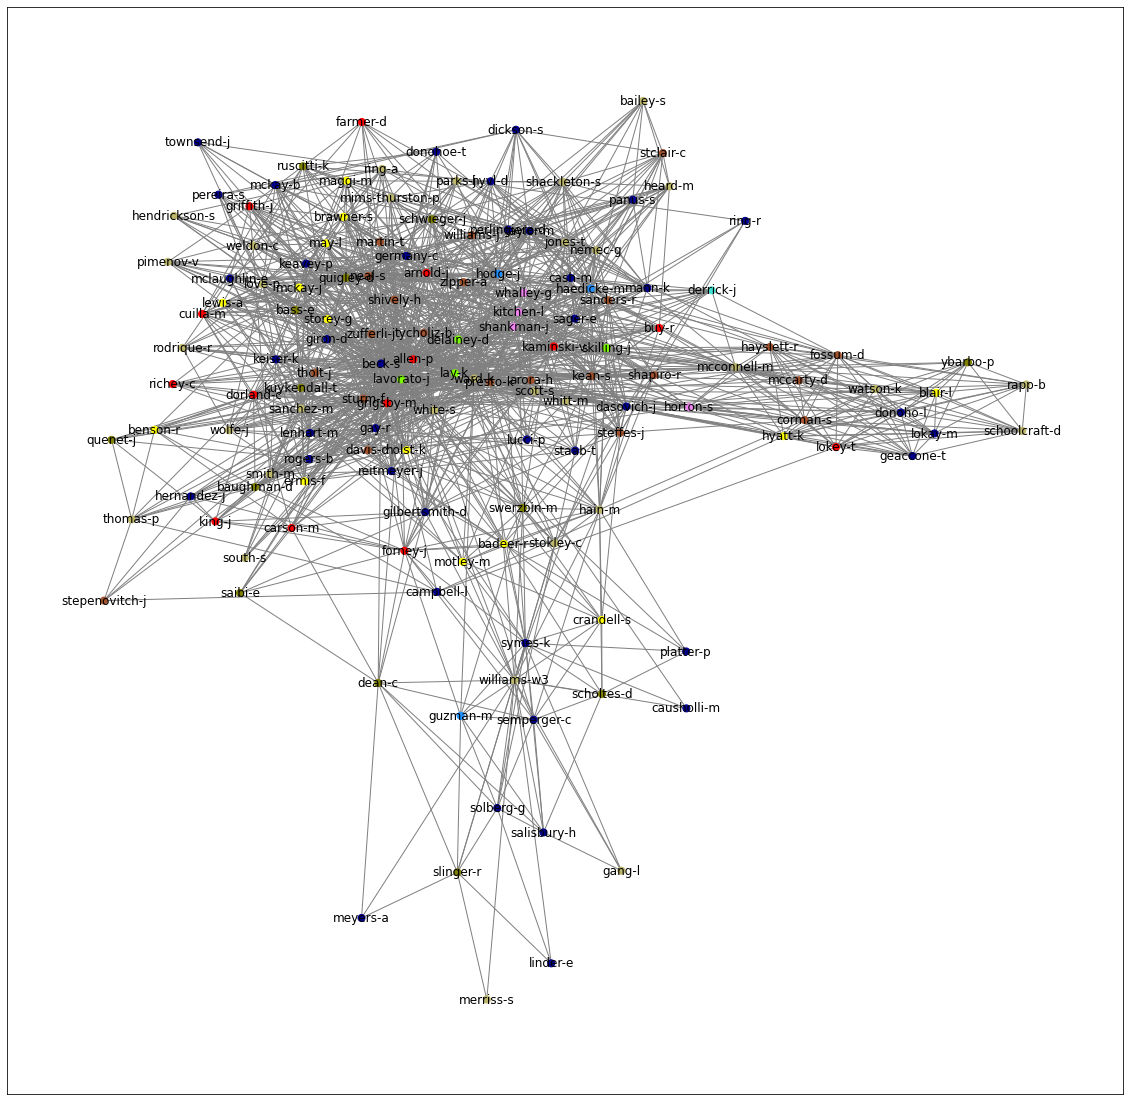

In [ ]:
# Static network
G = nx.from_pandas_edgelist(Enron_events, source = "exped", target = "destin", edge_attr = ["truetime"])
dict_Enron_positions = Enron_positions.set_index("id").to_dict("index")

node_color, node_labels = [], {} # for visualization
for node in G.nodes(data = True):
    node_info = dict_Enron_positions[node[0]] # get from the dict
    node_labels[node[0]] = node_info["person"]
    position = node_info["position"]
    if position == "Manager":
        node_color.append("red")
    elif position == "Vice President":
        node_color.append("sienna")
    elif position == "Director":
        node_color.append("yellow")
    elif position == "unknown":
        node_color.append("darkkhaki")
    elif position == "Trader":
        node_color.append("olive")
    elif position == "Employee":
        node_color.append("darkblue")
    elif position == "CEO":
        node_color.append("lawngreen")
    elif position == "In House Lawyer":
        node_color.append("turquoise")
    elif position == "Managing Director":
        node_color.append("dodgerblue")
    elif position == "President":
        node_color.append("violet")
    else: raise ValueError("unknown position")

plt.figure(figsize = (20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_size = 50, node_color = node_color, labels = node_labels, edge_color = "grey")

#### Statistical summaries and global characteristics

In [ ]:
density = nx.density(G)
print("Network density:", density)
diameter = nx.diameter(G)
print("Network diameter:", diameter)
transitivity = nx.transitivity(G)
print("Network transitivity:", transitivity)
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)
radius = nx.radius(G)
print("Network radius:", radius)

Network density: 0.14067076051015587
Network diameter: 4
Network transitivity: 0.39457474818232324
Triadic closure: 0.39457474818232324
Network radius: 2


In [ ]:
# Check if the graph connected
print(nx.is_connected(G))

True


####  Identify important vertices and specific groups of vertices sharing particular interactions by examining vertex degree and vertex betweeness 

In [ ]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 10 vextex by degree:")
for d in sorted_degree[:10]:
    print(d)

Top 10 vextex by degree:
(60, 80)
(8, 73)
(61, 63)
(88, 60)
(1, 55)
(23, 48)
(58, 47)
(41, 44)
(80, 41)
(124, 41)


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


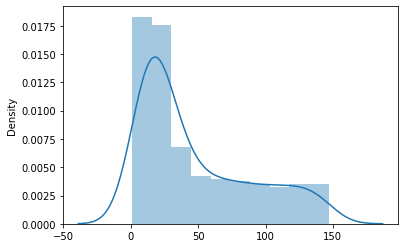

In [ ]:
sns.distplot(nx.degree(G), bins=10, kde=True)
plt.show()

In [ ]:
sorted_betweenness = sorted(nx.betweenness_centrality(G).items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by betweenness centrality:")
for b in sorted_betweenness[:10]:
    print(b)

Top 10 nodes by betweenness centrality:
(60, 0.12830714202028073)
(8, 0.09871751729970671)
(88, 0.07335617974061237)
(61, 0.0619069558961088)
(139, 0.055757407058792736)
(107, 0.04133567382718802)
(1, 0.027557692896952632)
(136, 0.025826512107008825)
(20, 0.02322938725859688)
(132, 0.023191566234780157)


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


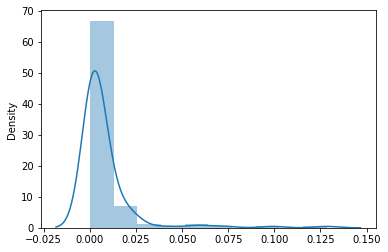

In [ ]:
betweenness = list(nx.betweenness_centrality(G).values())
sns.distplot(betweenness, bins=10, kde=True)
plt.show()

- Degree centrality, which basically measures the extent to which a given node is connected to all the other nodes.
- Betweenness centrality, which measures the degree to which each node is the 'single point of contact'.

From the result, we can see the top 10 nodes by betweenness centrality represent the top important vertices and top 10 vextex by degree represent the vertices with the most number of edges associated. In which, vertex with id number 60 (lay-k) is the most important vertex


#### Compare network with random graph

In [ ]:
nx.info(G)

'Graph with 146 nodes and 1489 edges'

In [ ]:
# Generate random graphs with the Erdos model
random.seed(2021)
B = 100 
global_char = []
for i in range(B):
    random_graph = ig.Graph.Erdos_Renyi(n=146,\
                                        m=1489, \
                     directed = False, loops = False)
    if random_graph.is_connected():
        global_char.append([random_graph.density(), 
                            random_graph.transitivity_undirected(),
                            random_graph.diameter()])

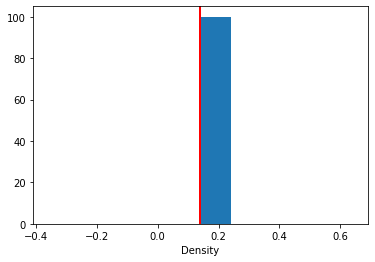

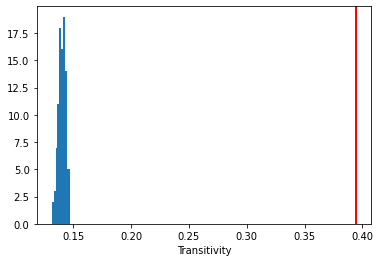

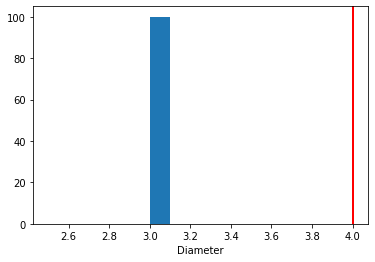

In [ ]:
global_char = pd.DataFrame.from_records(data=global_char, \
                        columns=['Density', 'Transitivity', 'Diameter'])

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(global_char['Density'])
ax1.axvline(x=nx.density(G), color='r', linewidth=2)
ax1.set_xlabel('Density')

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(global_char['Transitivity'])
ax2.axvline(x=nx.transitivity(G), color='r', linewidth=2)
ax2.set_xlabel('Transitivity')

fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
n, bins, patches = ax3.hist(global_char['Diameter'])
ax3.axvline(x=nx.diameter(G), color='r', linewidth=2)
ax3.set_xlabel('Diameter')

plt.show()

In [ ]:
global_char.describe()

,Density,Transitivity,Diameter
count,1.000000e+02,100.000000,100.0
mean,1.406708e-01,0.140401,3.0
std,2.789540e-17,0.003343,0.0
min,1.406708e-01,0.131581,3.0
25%,1.406708e-01,0.138112,3.0
50%,1.406708e-01,0.140727,3.0
75%,1.406708e-01,0.142681,3.0
max,1.406708e-01,0.147744,3.0


Network's summaries:
- Network density: 0.14067076051015587
- Network diameter: 4
- Network transitivity: 0.39457474818232324

Compare the random graph with our network, we can examine that the density is similar, the diameter and transivity of our network is larger which is indicate his indicates a larger local connectivity in our network than in a random graph with the same number of vertices and edges.
From that we can counclude the network is not a ramdom one.

In conclusion, the graph show us a complicated network interaction with lay-k, the founder and CEO as the key player. He has interaction with everyone and every group.

## 4. Temporal network

#### Temporal network with a daily aggregation level

In [ ]:
Enron_events_day = Enron_events.copy()
Enron_events_day["truetime"] = Enron_events_day["truetime"].dt.date
Enron_events_day["day"] = (Enron_events_day["truetime"] - Enron_events_day["truetime"].min()).dt.days
Enron_events_day = Enron_events_day.rename(columns = {"exped": "i", "destin": "j", "day": "t"})[["i","j","t"]] 

In [ ]:
import pathpy as pp

t = pp.TemporalNetwork()
[t.add_edge(Enron_events_day['i'][i],Enron_events_day['j'][i],int(Enron_events_day['t'][i])) for i in range(len(Enron_events_day))]
print(t)

Nodes:			146
Time-stamped links:	21267
Links/Nodes:		145.66438356164383
Observation period:	[0, 778]
Observation length:	 778 
Time stamps:		 633 
Avg. inter-event dt:	 1.231012658227848
Min/Max inter-event dt:	 1/29


In [ ]:
t

In [ ]:
pp.visualisation.export_html(t, 'my_temporal_network.html')

#### Statistics of temporal network (transitivity, mean degree, ...)

In [ ]:
tnet = TemporalNetwork(from_df = Enron_events_day)
tnet.network

,i,j,t
0,52,119,0
1,119,99,0
2,119,5,0
3,119,52,0
4,119,109,0
...,...,...,...
21262,83,37,737
21263,37,83,737
21264,37,136,766
21265,37,23,773


In [ ]:
print("Temporal degree of network:", tnet_m.temporal_degree_centrality(tnet), "\n\n")
print("Volatility of network:", tnet_m.volatility(tnet), "\n\n")
print("Fluctuability of network:", tnet_m.fluctuability(tnet), "\n\n")
# print("Shortest temporal path:", tnet_m.shortest_temporal_path(tnet), "\n\n") # TOO LONG
# print("Temporal closeness centrality per node:", tnet_m.temporal_closeness_centrality(tnet), "\n\n") # TOO LONG
# print("Inter-contact times of each edge in a network:", tnet_m.intercontacttimes(tnet), "\n\n") # TOO LONG
# print("Temporal efficiency estimate:", tnet_m.temporal_efficiency(tnet), "\n\n") # TOO LONG
# print("Reachability latency:", tnet_m.reachability_latency(tnet), "\n\n") # TOO LONG
# print("Temporal betweenness centrality per node:", tnet_m.temporal_betweenness_centrality(tnet), "\n\n") # TOO LONG

Temporal degree of network: [0.000e+00 3.020e+02 5.640e+02 8.000e+00 1.100e+01 8.000e+00 4.160e+02
 1.200e+01 3.040e+02 0.000e+00 2.020e+02 3.100e+01 4.400e+01 1.000e+01
 1.800e+01 3.900e+01 0.000e+00 1.120e+02 1.900e+01 5.700e+01 1.935e+03
 1.000e+00 4.000e+00 6.140e+02 4.700e+01 2.700e+01 8.400e+01 4.000e+00
 1.220e+02 5.000e+00 1.700e+01 0.000e+00 1.110e+02 1.650e+02 0.000e+00
 3.500e+01 1.460e+02 2.750e+02 8.000e+00 1.840e+02 9.000e+00 7.200e+02
 4.040e+02 1.660e+02 2.770e+02 6.000e+00 1.100e+01 3.200e+01 9.000e+00
 9.100e+01 7.100e+01 1.730e+02 1.755e+03 1.650e+02 4.810e+02 2.200e+01
 1.250e+02 7.000e+00 4.030e+02 5.300e+01 6.160e+02 8.900e+01 2.800e+02
 5.000e+00 1.410e+02 3.700e+01 3.490e+02 5.000e+01 5.000e+00 6.180e+02
 4.900e+01 3.000e+01 4.100e+01 1.570e+02 1.000e+00 6.700e+01 1.820e+02
 4.000e+00 3.400e+01 0.000e+00 2.820e+02 2.510e+02 3.000e+00 2.000e+01
 9.000e+00 4.370e+02 1.400e+01 2.000e+00 2.630e+02 1.000e+00 7.400e+01
 7.100e+01 2.100e+01 3.000e+00 4.700e+01 8.000e+0

#### Time series, Anomalies and Change-points detection
Coputing the network for each week. Build a time series with the mean degree of network of each week.

In [ ]:
# Devide the dataset into week data
display(Enron_events.head(2))
weeks = set(list(Enron_events["truetime"].dt.week))
years = set(list(Enron_events["truetime"].dt.year))
sub = []
for y in years:
  for i in weeks:
      Enron_events_of_that_year = Enron_events[Enron_events["truetime"].dt.year == y]
      Enron_events_of_that_week = Enron_events_of_that_year[Enron_events_of_that_year["truetime"].dt.week == i]
      sub.append(Enron_events_of_that_week)


,time,exped,destin,truetime
0,1,52,119,2000-04-27 01:19:01
1,7741,119,99,2000-04-27 03:28:01


<ipython-input-204-c00155229a21>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  weeks = set(list(Enron_events["truetime"].dt.week))
<ipython-input-204-c00155229a21>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  Enron_events_of_that_week = Enron_events_of_that_year[Enron_events_of_that_year["truetime"].dt.week == i]


In [ ]:
sub = [df for df in sub if not df.empty]

In [ ]:
# Calculate mean degree
mean_degree = []
for i in sub:
    G = nx.from_pandas_edgelist(i, source = "exped", target = "destin", edge_attr = ["truetime"])
    mean = nx.number_of_edges(G)/nx.number_of_nodes(G)
    mean_degree.append(mean)

In [ ]:
# Get the first day of the week for the time series
date = []
for i in sub:
    get = i.iloc[0]['truetime']
    date.append(get)

time_series = pd.DataFrame({'date' : date,'mean_degree' : mean_degree,})
time_series = time_series.set_index('date').sort_index()
time_series.head()

,mean_degree
date,
2000-04-27 01:19:01,1.148148
2000-05-02 00:53:01,1.233333
2000-05-08 02:39:01,1.243243
2000-05-15 02:37:01,1.170732
2000-05-23 01:51:01,1.200000


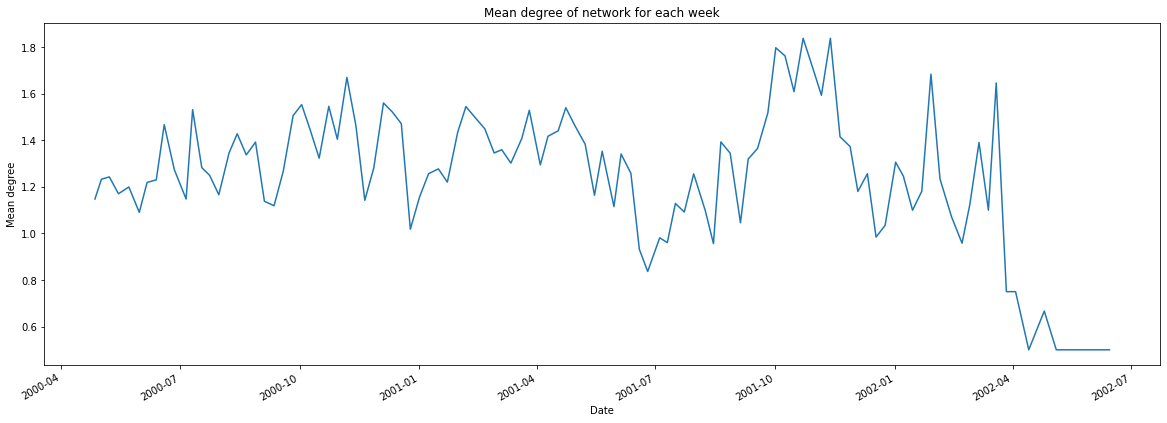

In [ ]:
time_series.plot(figsize=(20,7), legend=None, \
        title='Mean degree of network for each week')
plt.xlabel('Date')
plt.ylabel('Mean degree')
plt.show()

#### Stationarity Check

In [ ]:
r_t = np.log(time_series['mean_degree']/time_series['mean_degree'].shift(1)).values[:]
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([-0.00776914,  0.07157019,  0.00800295, -0.06009454,  0.02469261])

In [ ]:
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.979930
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


Comment: The series is stationary since test statistic of the Dickey test is less than 0.05.

#### Anomalies

We take the smallest 3 values as anomalies

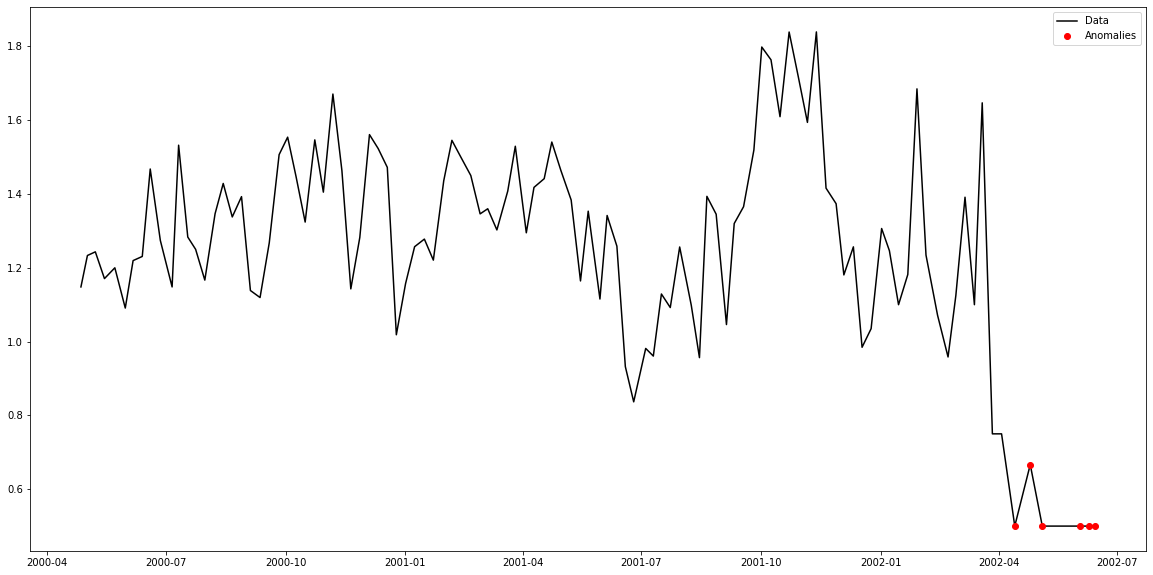

In [ ]:
# Compute the emprical 5% quantile and take all smaller values as anomalies
anomalies = time_series < time_series.quantile(0.05)
plt.figure(figsize=(20,10))
plt.plot(time_series,'k',label='Data')
plt.plot(time_series[anomalies],'ro',label='Anomalies')
plt.legend()
plt.show()

We detect six anomalies in the preiod of Apr 2002 to Jul 2000.
The degree of a node in a network is the number of connections. For the graph, we can observe low degree and some anomalies in the preiod of Apr 2002 to Jul 2000, which represent low number of email exchange in Enron

#### Change point
Aplly PELT on dectecting change point for optimal solution

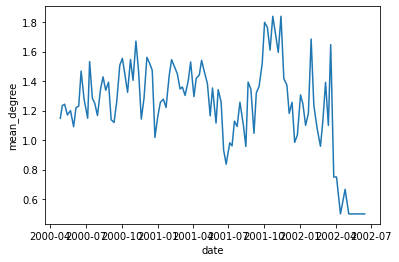

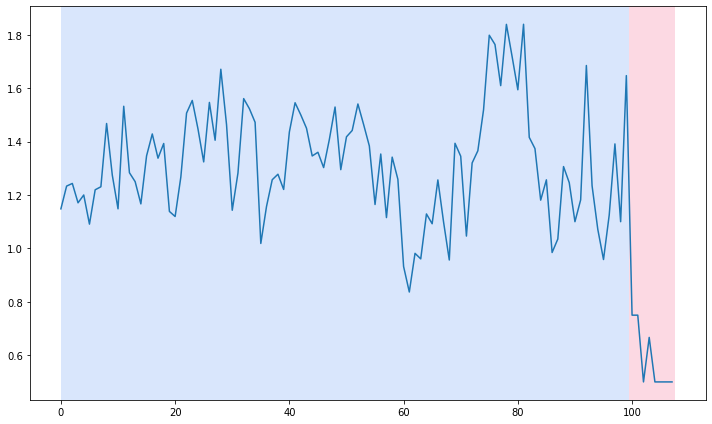

In [ ]:
sns.lineplot(x = 'date', y = 'mean_degree', data = time_series)

model = rpt.Pelt(model="l2", min_size=3, jump=5)
estim = model.fit(time_series['mean_degree'].to_numpy())
my_bkps = model.fit(time_series['mean_degree'].to_numpy()).predict(pen=3)
rpt.show.display(time_series['mean_degree'], my_bkps, figsize=(10, 6))
plt.show()

The series has one change point in the last part of the graph. It was the time the number of email exchange in Eron decreased